In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Analytical solution
u_star = lambda x: np.sin(math.pi * x)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

In [3]:
data_noise = 0.05

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(200, data_noise)

# Collocation points in (0,1)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)

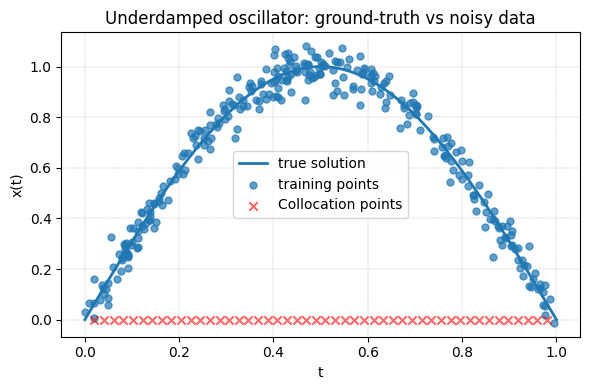

In [4]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [ ]:
# from draft import VIBPINN
from utils_uq_cp import CPPINN
cp_poisson_model = CPPINN(pde, 1, [16, 32, 32, 16], 1)
loss_dict = cp_poisson_model.fit_cp_pinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=10000, lr=3e-3,
                               λ_pde=1.0,λ_ic=0.0,λ_bc=1.0,)

Using device: cpu
Using device: cpu
ep     1 | L=5.18e+01 | data=7.98e-01 | pde=4.78e+01  ic=0.00e+00  bc=7.06e-02 | lr=3.00e-03
ep   500 | L=1.43e-02 | data=2.20e-03 | pde=3.29e-03  ic=0.00e+00  bc=2.58e-06 | lr=3.00e-03
ep  1000 | L=1.18e-02 | data=2.21e-03 | pde=7.45e-04  ic=0.00e+00  bc=1.19e-05 | lr=3.00e-03


In [6]:
distance_space = "feature"
neighbour_size = 20
alpha = 0.05

x_grid = torch.linspace(0, 1, 100).view(-1, 1)
pred_set = cp_poisson_model.predict(alpha, neighbour_size, 
                                    x_grid, X_calibration, Y_calibration, X_train, 
                                    distance_space)

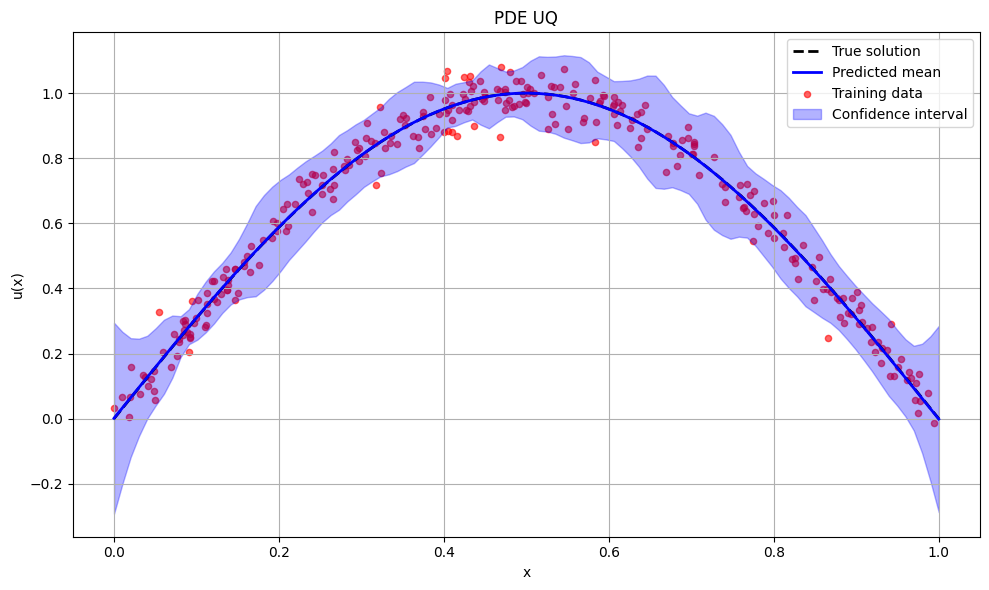

In [7]:
plot_predictions_1D(x_grid, pred_set, u_star, X=X_train, Y=Y_train)

## Sharpness & Coverage

100%|██████████| 8/8 [00:00<00:00, 444.82it/s]


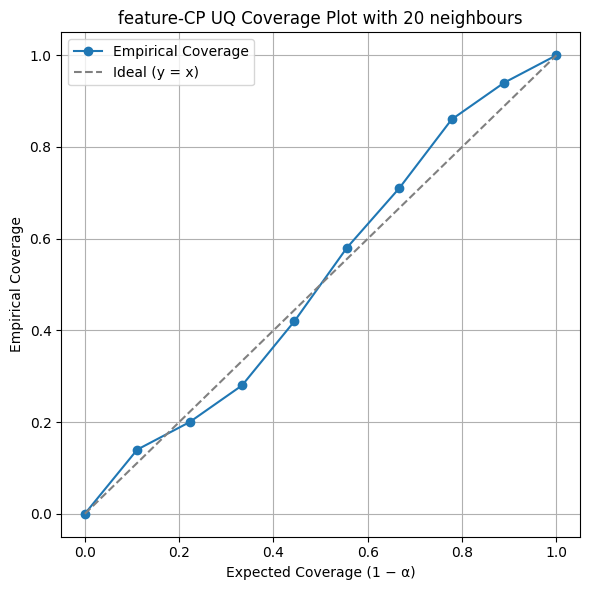

In [8]:
from utils_result_metrics import cp_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = cp_test_uncertainties(cp_poisson_model, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, distance_space, neighbour_size)
from utils_result_viz import plot_expected_vs_empirical
plot_expected_vs_empirical(rslt, title=f"{distance_space}-CP UQ Coverage Plot with {neighbour_size} neighbours")

## Uncertainty Plot


can clearly see where do we need more data point

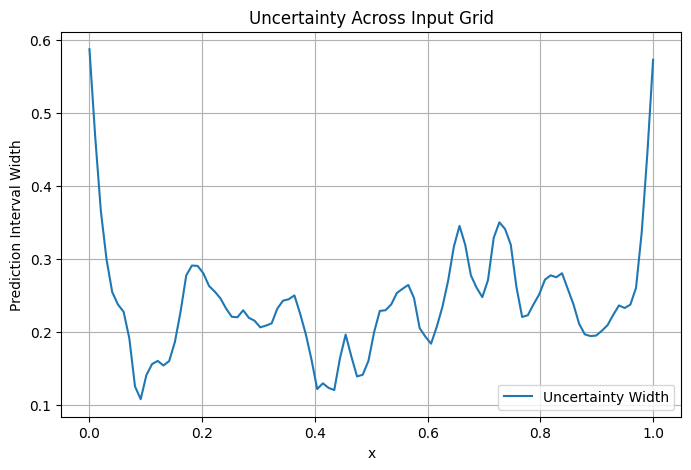

In [9]:
from utils_result_metrics import plot_uncertainty
plot_uncertainty(pred_set, x_grid)